In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import open3d as o3d
import nibabel as nib
from matplotlib import cm
from sklearn.model_selection import train_test_split

import matplotlib.transforms as mtransforms

In [34]:
FONT_TITLE_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'bold',
                   'fontsize': 14}

FONT_LABEL_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'normal',
                   'fontsize': 12}

FONT_LEGEND_PLOT = {'family': 'sans-serif',
                    'color':  'black', 
                    'fontweight': 'normal',
                    'fontsize': 12}


# Data import and partition

## Preprocessed data import
The data have already been preprocessed using the matlab class PSM (using the generateExportData function).

In [35]:
# Load vectorized VTA matrix
data = scipy.io.loadmat('data.mat')
X = np.array(data['X'])
y = np.squeeze(np.array(data['y']).T)

# Load template container
container = nib.load('container.nii')

# Load STN polygon
pcd_read = o3d.io.read_point_cloud('templates/anatomyDISTALminimal.ply')

# Assign global variable
CONTAINER_AFFINE = container.affine
CONTAINER_SHAPE = container.shape

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO - 2022-01-20 13:25:21,501 - batteryrunners - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## Create partitions of training and testing sets
The dataset is now split into the training and the testing set. In this script, no cross-validation will be performed.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot functions

Before going into the generation of the maps, this section creates function useful to observe and compare the probabilistic maps.

### Reconstruction of a VTA
As the data (the VTA voxels values) are provided under a vectorized form, it is necessary to be able to reconstruct the map. The first feature of the matrix is the intercept term and is cannot be displayed with the rest of the map voxels.

In [37]:
def logit(x):
    eps = 1e-9
    return np.log((x+eps)/(1-x+eps))

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(image):

    # create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()

def reconstruct(vector):
    # Function to reconstruct a vector into tensor based on the container shape

    intercept = vector[0]
    vector = vector[1:]
    tensor = np.reshape(vector, CONTAINER_SHAPE, order='F')

    return tensor, intercept

## Map plot
The plots of the map shall allow the vizualization of the map inside the MNI space. It is  important that the plot are easy to understand in order to give better insights about the stimulation sweet and sour spots. The function plot maps allows to plot the map in 3D (scatter) or see it in 2D as a image. In both cases the surrounding anatomy is displayed.

In [38]:
# Function used to visualize the different models
def plot_map(model,
             dim='2D', 
             plane='axial', 
             slice_index=int(CONTAINER_SHAPE[2]/2),
             view_angle=320, 
             marker='dot'):

    coef_tensor, coef_intercept = reconstruct(model.coef_)

    if dim == '2D':
        plot_slice(coef_tensor, slice_index, plane)
        
    elif dim == '3D':
        plot_cube(coef_tensor, view_angle, marker)


def plot_slice(tensor, slice_index, plane):
    # Function to plot a slice of the map on a 2D figure
    
    fig = plt.figure(figsize=(25/2.54, 25/2.54))
    ax = plt.axes()
    
    if plane == 'axial':
        plt.imshow(tensor[:, :, slice_index], cmap='coolwarm')
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'sagittal':
        plt.imshow(tensor[:, slice_index, :], cmap='coolwarm')
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'coronal':
        plt.imshow(tensor[slice_index, :, :], cmap='coolwarm')
        ax.set_xlabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    plt.show()

def plot_cube(cube, view_angle, marker):

    colors = cm.viridis(cube)
    alpha = normalize(np.power(np.abs(cube), 0.001))

    show_histogram(alpha)
    xx, yy, zz = np.indices(np.array(cube.shape))

    xx = xx.flatten()
    yy = yy.flatten()
    zz = zz.flatten()
    alpha = alpha.flatten()

    plt.figure(figsize=(20/2.54, 20/2.54))

    ax = plt.axes(projection='3d')
    ax.view_init(30, view_angle)
    ax.set_xlim(right=CONTAINER_SHAPE[0])
    ax.set_ylim(top=CONTAINER_SHAPE[1])
    ax.set_zlim(top=CONTAINER_SHAPE[2])

    if marker == 'dot':
        ax.scatter(xx, yy, zz, s=2, alpha=alpha, c=alpha, cmap='seismic', depthshade=False)

    elif marker == 'voxel':
        #ax.voxels(xx, yy, zz, colors, alpha=filled)
        ax.voxels(xx, yy, zz, facecolors=colors, edgecolor='k', shade=False)
    
    plt.show()

## Results plot
The results plot will be used in order to assess the quality of a model. It includes:
   - Prediction vs ground truth on testing set,
   - Prediction vs ground truth on training set,
   - Coefficient of determination of between variable prediction and ground truth,
   - Residual plot and QQ plot of those.

In [39]:
# Function used to visualize the accuracy of a model on testing and training data
def plot_results(model, X_test, y_test, X_train, y_train):

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    coef_deter_test = model.score(X_test, y_test)
    coef_deter_train = model.score(X_train, y_train)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2)

    # Set figure size and name
    fig.tight_layout()
    fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
    fig.set_size_inches(25/2.54, 25/2.54)

    # Set axe properties
    axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
    axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[0].scatter(pred_test, y_test, s=8)
    #axs[0].set_xlim([-0.05, 1.05])
    axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    #axs[0].set_ylim([-0.05, 1.05])
    axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    #axs[0].set_aspect('equal', 'box')

    axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
    axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[1].scatter(pred_train, y_train, s=8)
    #axs[1].set_xlim([-0.05, 1.05])
    axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    #axs[1].set_ylim([-0.05, 1.05])
    axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    #axs[1].set_aspect('equal', 'box')

    # Show figure
    plt.show()

    # Print the value of the R2
    print("Coefficient of determination (R²):")
    print("     - testing  :    ", coef_deter_test)
    print("     - training :    ", coef_deter_train)

TypeError: fit() missing 1 required positional argument: 'y'

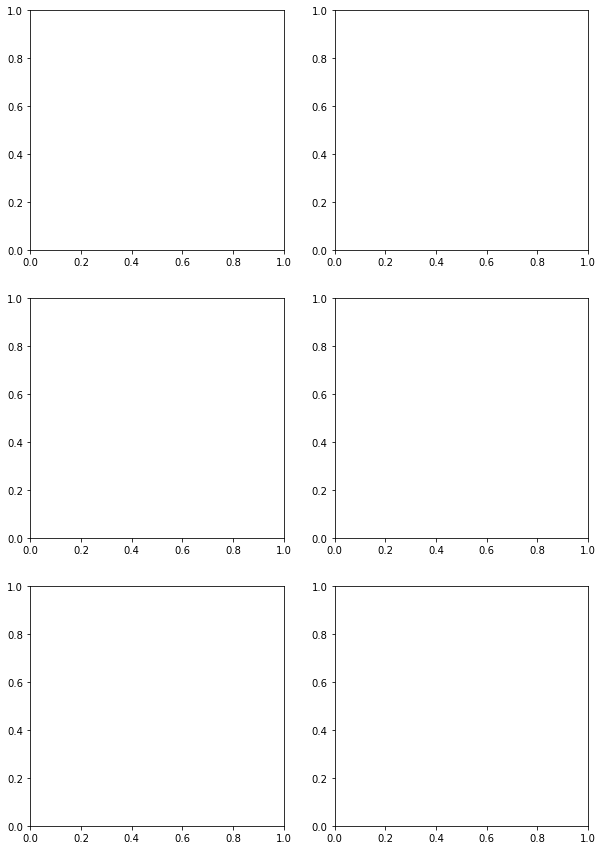

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB()
estimator.fit(X,)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

## Export map

In [40]:
def save_map(model):
    ni_img = nib.Nifti1Image(reconstruct(model.coef_)[0], CONTAINER_AFFINE)
    nib.save(ni_img, 'map.nii.gz')

# Probabilistic Stimulation for deep brain stimulation



first, I need to know wether it is a variance or a bias problem
to be assessed:
    - basic logistic regression
    - l1, l2 regularized logistic regression
    - bagging


## Linear Models
### Linear regression (response variable in unit interval)

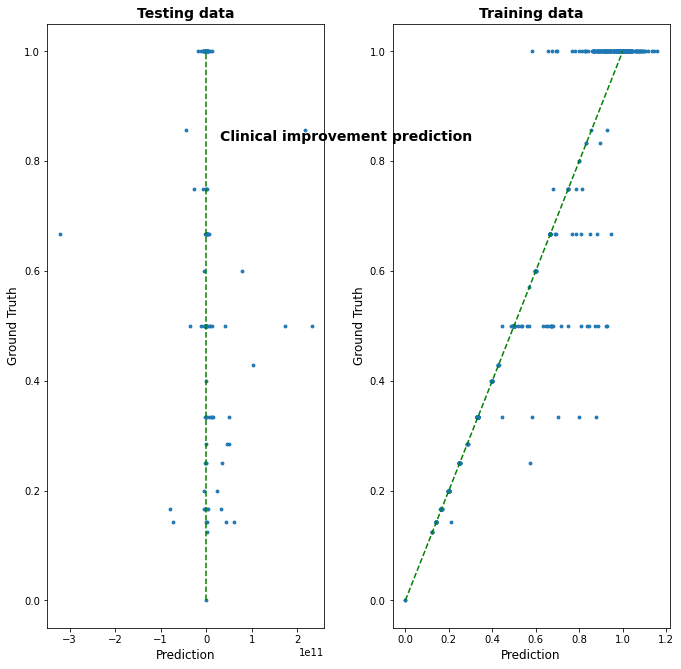

Coefficient of determination (R²):
     - testing  :     -1.6598072062796605e+22
     - training :     0.939848255279012


In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, y_train)

plot_results(model, X_test, y_test, X_train, y_train)

### Linear regression (response variable transformed in real positive)

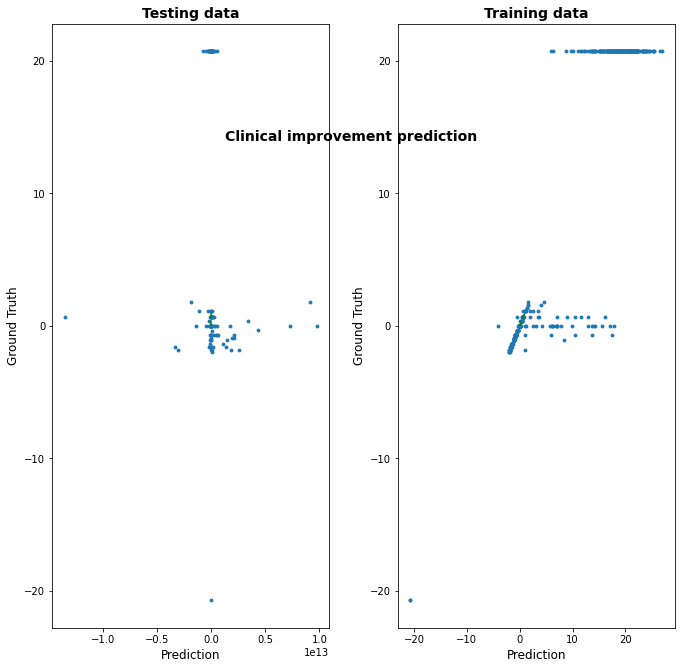

Coefficient of determination (R²):
     - testing  :     -2.4494424562278777e+22
     - training :     0.9168921215326643


In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()


y_train_trans = logit(y_train)
model = model.fit(X_train, logit(y_train))

plot_results(model, X_test, logit(y_test), X_train, logit(y_train))

### Bayesian Linear regression

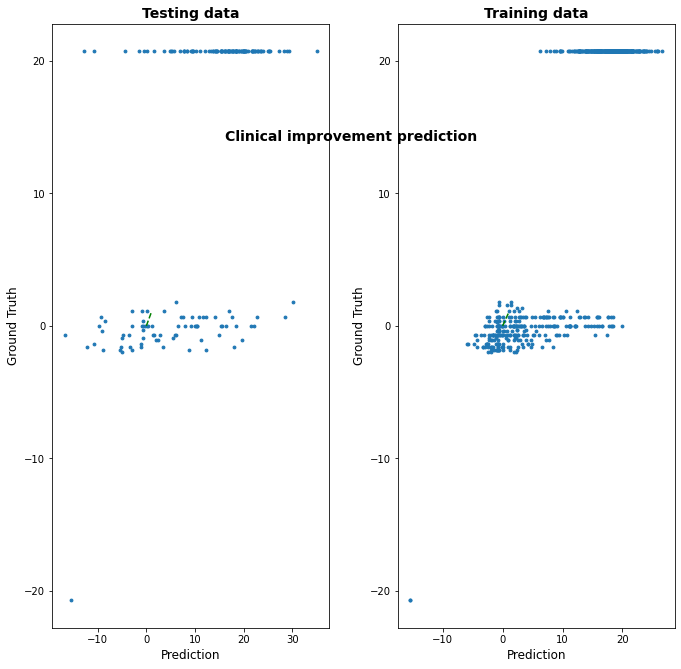

Coefficient of determination (R²):
     - testing  :     0.1321781338939384
     - training :     0.7538841163381486


In [41]:
from sklearn.linear_model import ARDRegression

model = ARDRegression()
model.fit(X_train, logit(y_train))
plot_results(model, X_test, logit(y_test), X_train, logit(y_train))

In [26]:


feature_selection = Lasso(alpha = 0.005, max_iter=1e4)
feature_selection.fit(X_train,y_train)

plot_results(feature_selection, X_test, y_test, X_train, y_train)
X_train_selected_feat = np.delete(X_train, np.where(feature_selection.coef_ == 0), 1)

logit = sm.Logit(y_train, X_train_selected_feat)
logit.fit()

NameError: name 'Lasso' is not defined

In [23]:
plot_results(logit, X_test, y_test, X_train, y_train)

ValueError: shapes (742,104) and (186,322849) not aligned: 104 (dim 1) != 186 (dim 0)

## Lasso regression

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha = 0.0001, max_iter=1e4)
model = model.fit(X_train, np.squeeze(y_train.T))

plot_results(model, X_test, y_test, X_train, y_train)


## Logistic Regression
Not possible because it relies on the Bernoulli distribution which is not applicable to a continuous variable as the clinical improvement. What we are looking for is more likely something like the beta-regression, which would model the distribution of the independant variable coming from a beta distribution.

## Bagging (SVR)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


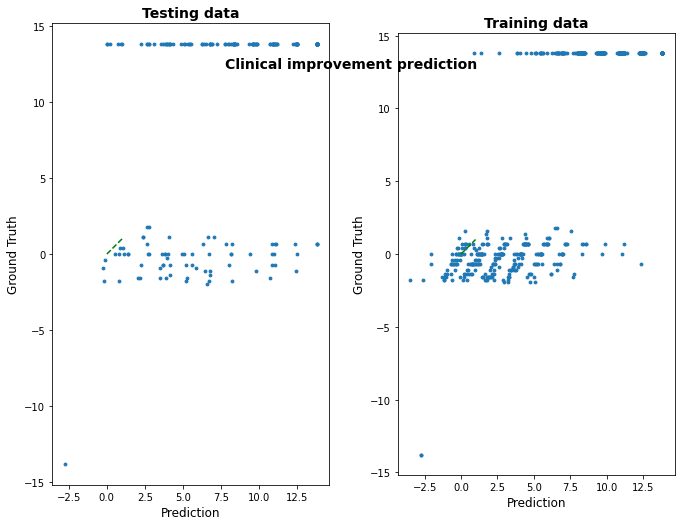

Coefficient of determination (R²):
     - testing  :     0.079087341015317
     - training :     0.7052847048635689


In [22]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

model = BaggingRegressor(n_estimators=10, random_state=0, verbose=1, max_samples=0.6,bootstrap_features=True, max_features=0.2)
model = model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

steps = [
    ("preprocessing", StandardScaler()),
    ("classifier", LogisticRegression()),
]
pipe = Pipeline(steps)


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

In [41]:
plot_map(model, dim='2D')

AttributeError: 'BaggingRegressor' object has no attribute 'coef_'

### Support Vector Regression

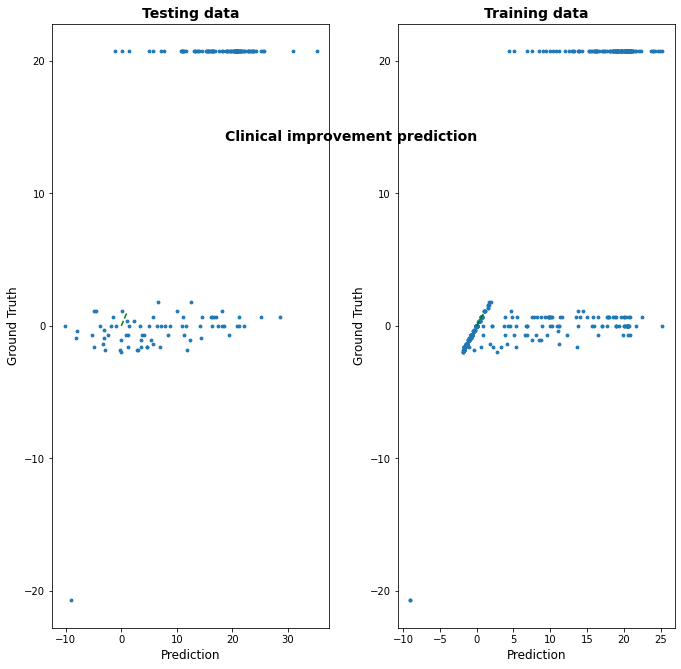

Coefficient of determination (R²):
     - testing  :     0.3683200898814235
     - training :     0.702362229457576


In [46]:
from sklearn.svm import SVR
model = SVR(kernel='linear')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, logit(y_train))
plot_results(model, X_test, logit(y_test), X_train, logit(y_train))

## Pipeline
### Dimensionality reduction

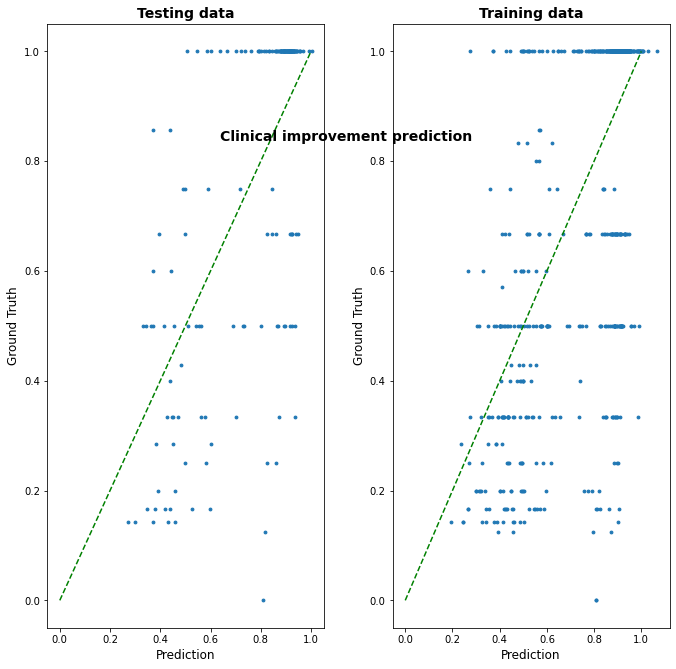

Coefficient of determination (R²):
     - testing  :     0.467263700189643
     - training :     0.45696884507476665


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import set_config

steps = [("reduce_dim", PCA(n_components=42)), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

### Feature selection

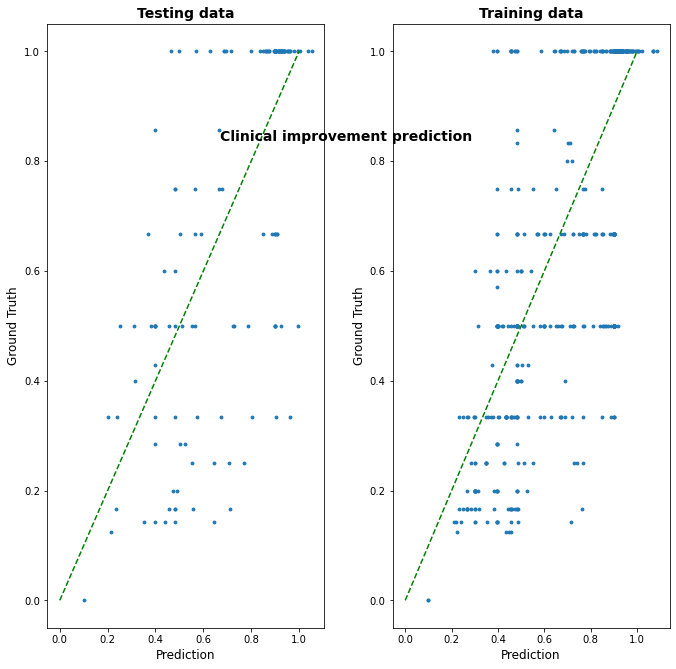

Coefficient of determination (R²):
     - testing  :     0.5310460491980771
     - training :     0.6438704384333687


AttributeError: 'Pipeline' object has no attribute 'coef_'

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

steps = [("feature selection", SelectFromModel(estimator=Lasso(alpha = 0.005))
), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)
plot_map(model, dim='2D')

In [22]:
save_map(model)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from scipy.special import expit, logit

X, y, coef = make_regression(n_samples=1000,
                             n_features=5,
                             n_informative=3,
                             noise=5.0,
                             coef=True,
                             random_state=0)

# mapping the data to the interval [0,1]
y = expit(y/50)   # the factor 50 just scales the data appropriately

print("The data was generated with the following coefficients:")
print(coef)

The data was generated with the following coefficients:
[10.71453179  0.          0.         66.49948238 41.20593377]


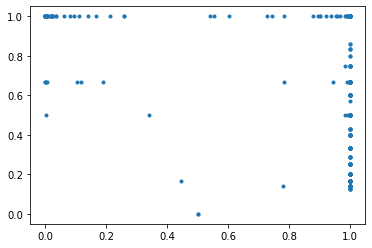

In [30]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

feature_selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_selected_feat = feature_selection.fit_transform(X_train)

# feature_selection = Lasso(alpha = 0.005, max_iter=1e4)
# feature_selection.fit(X_train,y_train)

#plot_results(feature_selection, X_test, y_test, X_train, y_train)
#X_train_selected_feat = np.delete(X_train, np.where(feature_selection.coef_ == 0), 1)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(logLikelihood, x0=x0, args=(np.squeeze(y_train.T), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
y_ = expit(np.dot(X_train_selected_feat,b))             # predictions
plt.plot(y_, y_train, ".")

In [68]:
b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
y_ = expit(np.dot(X_train_selected_feat,b))             # predictions
plt.plot(y_, y_train, ".")

ValueError: shapes (742,9982) and (105,) not aligned: 9982 (dim 1) != 105 (dim 0)

In [ ]:
from sklearn.feature_selection import RFE
